In [174]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import copy
import time
%pdb on

class StandardScaler(object):
    def __init__(self):
        pass

    def fit(self, X):'
        '''fit the scaler'''
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X - self.mean, axis=0)
        return self

    def transform(self, X):
        '''transform given X with the mean and standard deviation'''
        return (X - self.mean) / self.std

    def fit_transform(self, X):
        '''
        fit the scaler to given X, calculate mean and standard deviation
        then standardize the X with that mean and standard deviation
        '''
        return self.fit(X).transform(X)

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        y = np.atleast_2d(x)
        axis = -1
        y = y - np.expand_dims(np.max(y, axis = axis), axis)
        y = np.exp(y)
        summ = np.expand_dims(np.sum(y, axis = axis), axis)
        out = y / summ
        if len(x.shape) == 1: out = out.flatten()    
        return out
    
    def __softmax_deriv(self, a):
        "applies softmax derivative over the given array"
        return a * (1 - a)
    
    def __ReLU(self,x):
        """applies relu activation"""
        return x * (x > 0)
    
    def __ReLU_deriv(self,a):
        """returns derivative of relu activation"""
        return 1 * (a > 0)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        self.gamma = np.ones((1,n_out))
        self.beta = np.ones((1,n_out))
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.vel_W = np.zeros(self.W.shape)
        self.vel_b = np.zeros(self.b.shape)
        
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        if mode=='train':
            # Calculate linear output
            lin_output = np.dot(input, self.W) + self.b
            
            # If layer has activation, apply activation function to the linear output and set as output
            # Otherwise the layer is 
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
                )
                
            if self.dropout:
                self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=self.output.shape[-1])/(1-self.dropout)
                self.output = self.output * self.dropout_vector
            
        else:                
            lin_output = np.dot(input, self.W) + self.b
            
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
                )
                
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        
        if self.dropout: self.dropout_vector*self.grad_W
            
        self.grad_b = np.sum(delta,axis=0)
        
        if self.activation_deriv: delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
            
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh'], dropout=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.mode = 'train'
        self.activation=activation
        self.dropout=dropout
        self.batch_size = 1
        self.weight_decay = 0
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))
            
    def train(self):
        """
        sets network mode to train, enables dropout
        """
        self.mode = 'train'
    
    def test(self):
        """
        sets network mode to train, disables dropout
        """
        self.mode = 'test'

    def forward(self,input):
        """
        main forward step that triggers consecutive forward steps in each layer
        :param input: array of inputs
        :returns output: resulting output from all forward passes
        """
        for layer in self.layers:
            output=layer.forward(input=input, mode=self.mode)
            input=output
        return output

    def criterion_MSE(self,y,y_hat):
        """
        Criterion that uses Cross Entropy Loss Function 
        on actual and predicted labels and returns loss and delta
        :param y: actual target labels
        :param y_hat: predicted target labels
        """
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=np.sum(error**2)
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)
        # return loss and delta
        print(loss)
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        """
        Criterion that uses Cross Entropy Loss Function 
        on actual and predicted labels and returns loss and delta
        :param y: actual target labels
        :param y_hat: predicted target labels
        """
        error = y * np.log(y_hat)
        loss = -np.sum(error)
        delta = y_hat-y
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        """
        Update step that uses layer gradients and learning rate
        """
        for layer in self.layers:
            if self.momentum!=0:
                layer.vel_W = layer.vel_W * self.momentum + layer.grad_W * self.lr
                layer.vel_b = layer.vel_b * self.momentum + layer.grad_b * self.lr
                
                layer.W -= (layer.vel_W + layer.W * self.weight_decay)
                layer.b -= (layer.vel_b + layer.b * self.weight_decay)
            else:
                layer.W -= (lr * layer.grad_W + layer.W * self.weight_decay)
                layer.b -= (lr * layer.grad_b + layer.b * self.weight_decay)
            
    def get_batches(self,X, y, batch_size):
        """
        Shuffles and splits inputs X,y into batches and returns a list of batches
        :param X: Input data or features
        :param y: Input targets
        :param batch_size: Requested size for batches to be returned
        
        """
        batches = []

        X, y = self.shuffle(X, y)

        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            
            batches.append((X_batch, y_batch))

        return batches

    def fit(self,X,y,learning_rate=0.1, epochs=10, batch_size=1, momentum=0, weight_decay=0):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.batch_size=batch_size
        self.momentum = momentum
        self.lr = learning_rate
        self.weight_decay = weight_decay
        
        X=np.array(X)
        y=np.array(y)
        epoch_av_loss = np.zeros(epochs)
        y_dummies = np.array(pd.get_dummies(y))
        
        self.train()
        
        # Differentiate Stochastic Gradient Descent vs Batch Gradient Descent
        if batch_size>1:
            batches = self.get_batches(X, y_dummies, batch_size)
            for k in range(epochs):
                sum_loss = 0
                for X_batch,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X_batch)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        loss,delta=self.criterion_MSE(y_dummies,y_hat)
                    
                    sum_loss += loss
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate)
                epoch_av_loss[k] = sum_loss/X.shape[0]
        else:
            for k in range(epochs):
                loss=np.zeros(X.shape[0])
                for it in range(X.shape[0]):
                    i=np.random.randint(X.shape[0])
                    # forward pass
                    y_hat = self.forward(X[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y_dummies[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y_dummies[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                epoch_av_loss[k] = np.mean(loss)
        return epoch_av_loss
    
    def shuffle(self, x,y):
        """
        shuffles given input and target variables of same first axis shape
        :returns x,y: shuffled input and target
        """
        idxs = [idx for idx in range(x.shape[0])]
        np.random.shuffle(idxs)
        return x[idxs], y[idxs]

    def predict(self, x):
        """
        predict target variables based on inputs
        :returns yhat: an array of predictions
        """
        self.test()
        x = np.array(x)
        yhat = self.forward(x)
        if self.activation[-1]=='softmax':
            yhat = np.argmax(yhat,axis=1)
        return yhat
    
    def model_checkpointer(self, X, y, learning_rate=0.001, test_size=0.25, batch_size=1,epochs=10, momentum=0, weight_decay=0, verbose=True):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.best_accuracy = 0
        self.best_model = None
        self.batch_size=batch_size
        self.momentum = momentum
        self.lr = learning_rate
        self.weight_decay = weight_decay
        
        self.train()
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()
        #scaler = Normalizer()
        #scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        epoch_av_loss = np.zeros(epochs)
        accuracies_val = []
        accuracies_test = []
        if batch_size>1:
            batches = self.get_batches(X_train, y_train, batch_size)
            for k in range(epochs):
                sum_loss = 0
                
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                
                self.train()
                for X_batch,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X_batch)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        loss,delta=self.criterion_MSE(y_dummies,y_hat)
                    
                    sum_loss += loss
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate)
                epoch_av_loss[k] = sum_loss/X_train.shape[0]
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)
                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, epoch_av_loss[k]))
                    
                if accuracy_val > self.best_accuracy:
                    self.best_accuracy = accuracy_val
                    self.best_model = copy.deepcopy(self)
        else:
            for k in range(epochs):
                loss = np.zeros(X_train.shape[0])
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                self.train()
                for it in range(X_train.shape[0]):
                    i=np.random.randint(X_train.shape[0])
                
                    # forward pass
                    y_hat = self.forward(X_train[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y_train[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y_train[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)
                
                if accuracy_val > self.best_accuracy:
                    self.best_accuracy = accuracy_val
                    self.best_model = copy.deepcopy(self)
                
                epoch_av_loss[k] = np.mean(loss)

                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, np.mean(loss)))
                    
        return epoch_av_loss, accuracies_val, accuracies_test

Automatic pdb calling has been turned ON


## FIT REQUESTED PARAMETERS ONLY

In [170]:
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
mlp = MLP([128,128,128,128,10],activation=[None,'logistic','logistic','logistic','softmax'], dropout=[0.0, 0.0, 0.0, 0.0, 0.0])

mlp.fit(X_train, y_train, learning_rate=0.001, batch_size=100, momentum=0.9, weight_decay=0.000, epochs=10)
predictions = mlp.predict(X_val)
#predictions.to_csv('output/Predicted_labels.h5')
print('Accuracy for these settings : {}'.format((predictions==y_val).mean()))

with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = predictions)

Accuracy for these settings : 0.8193958333333333


## Split into train and validation sets, use cross validation to optimize parameters, then refit to whole data, predict test data and save into .h5 file.

## Sigmoid Architecture

C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:239: RuntimeWarning: divide by zero encountered in log
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in multiply


Epoch: 0..
train Accuracy: 0.414 
Validation Accuracy: 0.3993333333333333 
Loss: nan 

Epoch: 1..
train Accuracy: 0.5724444444444444 
Validation Accuracy: 0.5426666666666666 
Loss: nan 

Epoch: 2..
train Accuracy: 0.6974444444444444 
Validation Accuracy: 0.677 
Loss: nan 

Epoch: 3..
train Accuracy: 0.7773333333333333 
Validation Accuracy: 0.7446666666666667 
Loss: nan 

Epoch: 4..
train Accuracy: 0.7996666666666666 
Validation Accuracy: 0.7676666666666667 
Loss: nan 

Epoch: 5..
train Accuracy: 0.8201111111111111 
Validation Accuracy: 0.7803333333333333 
Loss: nan 

Epoch: 6..
train Accuracy: 0.8333333333333334 
Validation Accuracy: 0.792 
Loss: nan 

Epoch: 7..
train Accuracy: 0.8461111111111111 
Validation Accuracy: 0.8026666666666666 
Loss: nan 

Epoch: 8..
train Accuracy: 0.851 
Validation Accuracy: 0.802 
Loss: nan 

Epoch: 9..
train Accuracy: 0.8584444444444445 
Validation Accuracy: 0.808 
Loss: nan 

Epoch: 10..
train Accuracy: 0.8704444444444445 
Validation Accuracy: 0.8076666

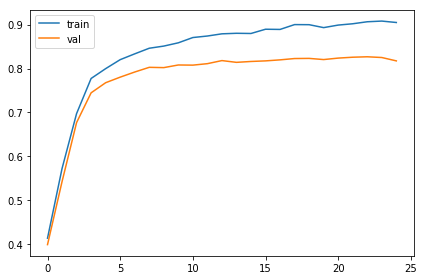

In [181]:
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

mlp = MLP([128, 64, 32, 10],activation=[None,'logistic', 'logistic', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

start = time.time()
losses1, accuracies_train1, accuracies_val1 = mlp.model_checkpointer(X_train, y_train, learning_rate=0.001, batch_size=32, momentum=0.9, weight_decay=0.0, epochs=25)
end = time.time()

plt.plot(accuracies_train1, label='train')
plt.plot(accuracies_val1, label='val')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_logistic.png')

print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.predict(scaled_test_data)

with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

## Relu Architecture [128,64,32,10] Dropout = 0.1, Batch_Size =16, LR=0.001, momentum=25, epochs=25

C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: divide by zero encountered in log
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in multiply


Epoch: 0..
train Accuracy: 0.6175555555555555 
Validation Accuracy: 0.6066666666666667 
Loss: nan 

Epoch: 1..
train Accuracy: 0.7903333333333333 
Validation Accuracy: 0.7783333333333333 
Loss: nan 

Epoch: 2..
train Accuracy: 0.8253333333333334 
Validation Accuracy: 0.8093333333333333 
Loss: nan 

Epoch: 3..
train Accuracy: 0.8505555555555555 
Validation Accuracy: 0.8263333333333334 
Loss: nan 

Epoch: 4..
train Accuracy: 0.8594444444444445 
Validation Accuracy: 0.8323333333333334 
Loss: nan 

Epoch: 5..
train Accuracy: 0.8702222222222222 
Validation Accuracy: 0.8426666666666667 
Loss: nan 

Epoch: 6..
train Accuracy: 0.8808888888888889 
Validation Accuracy: 0.849 
Loss: nan 

Epoch: 7..
train Accuracy: 0.8862222222222222 
Validation Accuracy: 0.8543333333333333 
Loss: nan 

Epoch: 8..
train Accuracy: 0.8905555555555555 
Validation Accuracy: 0.851 
Loss: nan 

Epoch: 9..
train Accuracy: 0.8974444444444445 
Validation Accuracy: 0.854 
Loss: nan 

Epoch: 10..
train Accuracy: 0.901333333

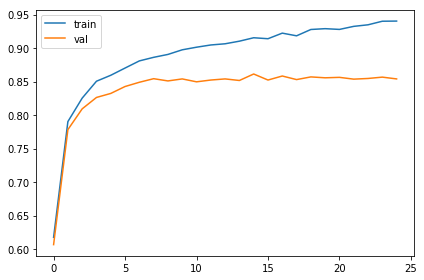

In [172]:
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

mlp = MLP([128, 64, 32, 10],activation=[None,'ReLU', 'ReLU', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

start = time.time()

losses, accuracies_train, accuracies_val = mlp.model_checkpointer(X_train, y_train, learning_rate=0.0001 , batch_size=16, momentum=0.9, weight_decay=0.0, epochs=25)

end = time.time()

print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_val, label='val')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_logistic.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

## %87.3 Accuracy Relu Architecture [128,64,32,10] Dropout = 0.0, Batch_Size =32, LR=0.001, epochs=25

Epoch: 0..
train Accuracy: 0.8515333333333334 
Validation Accuracy: 0.8407333333333333 
Loss: 0.8283221136499678 

Epoch: 1..
train Accuracy: 0.8727777777777778 
Validation Accuracy: 0.8584 
Loss: 0.40298483674284274 

Epoch: 2..
train Accuracy: 0.8845777777777778 
Validation Accuracy: 0.8642 
Loss: 0.3549353630683583 

Epoch: 3..
train Accuracy: 0.8928 
Validation Accuracy: 0.8681333333333333 
Loss: 0.3265217685447461 

Epoch: 4..
train Accuracy: 0.8993777777777778 
Validation Accuracy: 0.8722 
Loss: 0.3057627803327791 

Epoch: 5..
train Accuracy: 0.9042666666666667 
Validation Accuracy: 0.8724666666666666 
Loss: 0.2892925159246798 

Epoch: 6..
train Accuracy: 0.9086666666666666 
Validation Accuracy: 0.8732666666666666 
Loss: 0.2754605009100264 

Epoch: 7..
train Accuracy: 0.9121777777777778 
Validation Accuracy: 0.8746 
Loss: 0.2636464953745678 

Epoch: 8..
train Accuracy: 0.9159333333333334 
Validation Accuracy: 0.8748666666666667 
Loss: 0.25340097721613436 

Epoch: 9..
train Accura

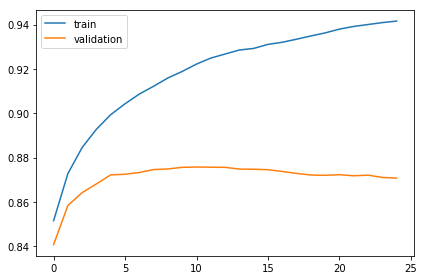

In [224]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 64, 32, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.0, 0.0, 0.0, 0])

start = time.time()

losses1, accuracies_train1, accuracies_test1 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=25)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train1, label='train')
plt.plot(accuracies_test1, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy1 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

## %89 Accuracy Relu Architecture [128,64,32,10] Dropout = 0.1, Batch_Size =32, LR=0.001, epochs=15

Epoch: 0..
train Accuracy: 0.8684666666666667 
Validation Accuracy: 0.8488666666666667 
Loss: 0.7795316972812367 

Epoch: 1..
train Accuracy: 0.8866888888888889 
Validation Accuracy: 0.8641333333333333 
Loss: 0.4189868006509938 

Epoch: 2..
train Accuracy: 0.8983111111111111 
Validation Accuracy: 0.8706 
Loss: 0.36299340217571147 

Epoch: 3..
train Accuracy: 0.9066222222222222 
Validation Accuracy: 0.8746666666666667 
Loss: 0.3297043938230278 

Epoch: 4..
train Accuracy: 0.9159111111111111 
Validation Accuracy: 0.8764 
Loss: 0.3057045123816969 

Epoch: 5..
train Accuracy: 0.9233111111111111 
Validation Accuracy: 0.8784 
Loss: 0.28430658673080494 

Epoch: 6..
train Accuracy: 0.9284 
Validation Accuracy: 0.8805333333333333 
Loss: 0.2680014446047853 

Epoch: 7..
train Accuracy: 0.9316666666666666 
Validation Accuracy: 0.8826666666666667 
Loss: 0.2514934264929249 

Epoch: 8..
train Accuracy: 0.9361777777777778 
Validation Accuracy: 0.8846666666666667 
Loss: 0.24023645875538507 

Epoch: 9..

Epoch: 74..
train Accuracy: 0.9967333333333334 
Validation Accuracy: 0.8837333333333334 
Loss: 0.05918598349524977 

Epoch: 75..
train Accuracy: 0.9978222222222223 
Validation Accuracy: 0.8858 
Loss: 0.059221917964001274 

Epoch: 76..
train Accuracy: 0.9976666666666667 
Validation Accuracy: 0.8858 
Loss: 0.05938424795638101 

Epoch: 77..
train Accuracy: 0.9971333333333333 
Validation Accuracy: 0.8847333333333334 
Loss: 0.05933581507313978 

Epoch: 78..
train Accuracy: 0.9979555555555556 
Validation Accuracy: 0.886 
Loss: 0.05648449113141367 

Epoch: 79..
train Accuracy: 0.9975555555555555 
Validation Accuracy: 0.8859333333333334 
Loss: 0.053733142314202044 

Time taken to train and predict: 107.75 seconds
Best accuracy achieved: 0.889 accuracy


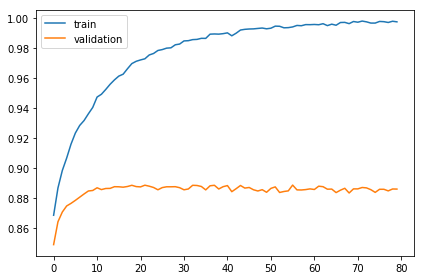

In [186]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.1, 0.1, 0.0, 0])

start = time.time()

losses2, accuracies_train2, accuracies_test2 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train2, label='train')
plt.plot(accuracies_test2, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy2 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

Epoch: 0..
train Accuracy: 0.8548 
Validation Accuracy: 0.8448 
Loss: 0.9026887131840226 

Epoch: 1..
train Accuracy: 0.8729111111111111 
Validation Accuracy: 0.8598 
Loss: 0.4854968887186174 

Epoch: 2..
train Accuracy: 0.8812222222222222 
Validation Accuracy: 0.8645333333333334 
Loss: 0.4253213013684887 

Epoch: 3..
train Accuracy: 0.8919555555555555 
Validation Accuracy: 0.8717333333333334 
Loss: 0.38896520224703895 

Epoch: 4..
train Accuracy: 0.8956666666666667 
Validation Accuracy: 0.8749333333333333 
Loss: 0.36707356358953824 

Epoch: 5..
train Accuracy: 0.9032888888888889 
Validation Accuracy: 0.8768 
Loss: 0.34411247797811045 

Epoch: 6..
train Accuracy: 0.9062222222222223 
Validation Accuracy: 0.8786 
Loss: 0.330765184962419 

Epoch: 7..
train Accuracy: 0.9106222222222222 
Validation Accuracy: 0.8819333333333333 
Loss: 0.3164292261972708 

Epoch: 8..
train Accuracy: 0.9153555555555556 
Validation Accuracy: 0.8824666666666666 
Loss: 0.3089869937247179 

Epoch: 9..
train Accura

Epoch: 74..
train Accuracy: 0.9877777777777778 
Validation Accuracy: 0.8929333333333334 
Loss: 0.12056076503099761 

Epoch: 75..
train Accuracy: 0.9879777777777777 
Validation Accuracy: 0.8914 
Loss: 0.12040479833859452 

Epoch: 76..
train Accuracy: 0.9890444444444444 
Validation Accuracy: 0.8915333333333333 
Loss: 0.12111737875579064 

Epoch: 77..
train Accuracy: 0.9883555555555555 
Validation Accuracy: 0.8906666666666667 
Loss: 0.11708166480087569 

Epoch: 78..
train Accuracy: 0.9886444444444444 
Validation Accuracy: 0.8907333333333334 
Loss: 0.11952175035932068 

Epoch: 79..
train Accuracy: 0.9896222222222222 
Validation Accuracy: 0.8917333333333334 
Loss: 0.11743066845601419 

Time taken to train and predict: 106.63 seconds
Best accuracy achieved: 0.894 accuracy


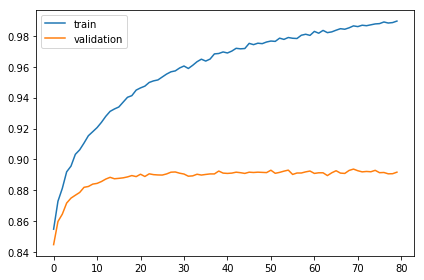

In [225]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.2, 0.2, 0.0, 0])

start = time.time()

losses3, accuracies_train3, accuracies_test3 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train3, label='train')
plt.plot(accuracies_test3, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy3 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

Epoch: 0..
train Accuracy: 0.8454222222222222 
Validation Accuracy: 0.8356666666666667 
Loss: 1.1137049400623422 

Epoch: 1..
train Accuracy: 0.8623777777777778 
Validation Accuracy: 0.8505333333333334 
Loss: 0.5684601932940719 

Epoch: 2..
train Accuracy: 0.8718 
Validation Accuracy: 0.8588 
Loss: 0.4941280174195591 

Epoch: 3..
train Accuracy: 0.8773555555555556 
Validation Accuracy: 0.8622 
Loss: 0.45436493457429494 

Epoch: 4..
train Accuracy: 0.8806666666666667 
Validation Accuracy: 0.8654 
Loss: 0.43154661777834236 

Epoch: 5..
train Accuracy: 0.8866444444444445 
Validation Accuracy: 0.8703333333333333 
Loss: 0.40822110619200225 

Epoch: 6..
train Accuracy: 0.8896 
Validation Accuracy: 0.8706666666666667 
Loss: 0.392216872989529 

Epoch: 7..
train Accuracy: 0.8909777777777778 
Validation Accuracy: 0.8709333333333333 
Loss: 0.3803562842716433 

Epoch: 8..
train Accuracy: 0.8964444444444445 
Validation Accuracy: 0.8737333333333334 
Loss: 0.36234520390815 

Epoch: 9..
train Accuracy

Epoch: 74..
train Accuracy: 0.9686222222222223 
Validation Accuracy: 0.8965333333333333 
Loss: 0.1798904532275335 

Epoch: 75..
train Accuracy: 0.9698 
Validation Accuracy: 0.8980666666666667 
Loss: 0.17872633018732415 

Epoch: 76..
train Accuracy: 0.9710888888888889 
Validation Accuracy: 0.8985333333333333 
Loss: 0.17960843404088417 

Epoch: 77..
train Accuracy: 0.9704888888888888 
Validation Accuracy: 0.898 
Loss: 0.1767677505717768 

Epoch: 78..
train Accuracy: 0.9709333333333333 
Validation Accuracy: 0.8986666666666666 
Loss: 0.17462439239288777 

Epoch: 79..
train Accuracy: 0.9719777777777778 
Validation Accuracy: 0.8991333333333333 
Loss: 0.17500053016120054 

Epoch: 80..
train Accuracy: 0.9704888888888888 
Validation Accuracy: 0.8994666666666666 
Loss: 0.17337291979748054 

Epoch: 81..
train Accuracy: 0.9728888888888889 
Validation Accuracy: 0.8989333333333334 
Loss: 0.17342644618236072 

Epoch: 82..
train Accuracy: 0.9736444444444444 
Validation Accuracy: 0.9001333333333333 
Lo

Epoch: 148..
train Accuracy: 0.9880222222222222 
Validation Accuracy: 0.8990666666666667 
Loss: 0.12898953623331808 

Epoch: 149..
train Accuracy: 0.9889777777777777 
Validation Accuracy: 0.9000666666666667 
Loss: 0.1345127720878133 

Time taken to train and predict: 202.36 seconds
Best accuracy achieved: 0.902 accuracy


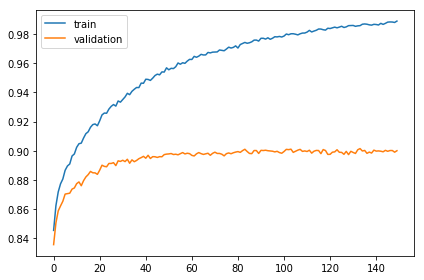

In [203]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.3, 0.3, 0.0, 0])

start = time.time()

losses4, accuracies_train4, accuracies_test4 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=150)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train4, label='train')
plt.plot(accuracies_test4, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions4 = mlp.best_model.predict(scaled_test_data)

best_accuracy4 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

Epoch: 0..
train Accuracy: 0.8262888888888889 
Validation Accuracy: 0.8098 
Loss: 1.3836476242095745 

Epoch: 1..
train Accuracy: 0.8467111111111111 
Validation Accuracy: 0.8314666666666667 
Loss: 0.7057894256296858 

Epoch: 2..
train Accuracy: 0.8581111111111112 
Validation Accuracy: 0.8423333333333334 
Loss: 0.584547151132998 

Epoch: 3..
train Accuracy: 0.8635777777777778 
Validation Accuracy: 0.8467333333333333 
Loss: 0.5349381646875556 

Epoch: 4..
train Accuracy: 0.8693333333333333 
Validation Accuracy: 0.8528 
Loss: 0.5061187719852946 

Epoch: 5..
train Accuracy: 0.8729555555555556 
Validation Accuracy: 0.8556666666666667 
Loss: 0.48054018046453345 

Epoch: 6..
train Accuracy: 0.8767555555555555 
Validation Accuracy: 0.8596 
Loss: 0.46376699776103586 

Epoch: 7..
train Accuracy: 0.8813777777777778 
Validation Accuracy: 0.8617333333333334 
Loss: 0.44525440664459415 

Epoch: 8..
train Accuracy: 0.8847333333333334 
Validation Accuracy: 0.8631333333333333 
Loss: 0.4333250627095039 


Epoch: 74..
train Accuracy: 0.9515555555555556 
Validation Accuracy: 0.8954666666666666 
Loss: 0.23577835909658662 

Epoch: 75..
train Accuracy: 0.9508888888888889 
Validation Accuracy: 0.8958 
Loss: 0.23575188004131503 

Epoch: 76..
train Accuracy: 0.9516 
Validation Accuracy: 0.8959333333333334 
Loss: 0.23272622826151954 

Epoch: 77..
train Accuracy: 0.9522666666666667 
Validation Accuracy: 0.8948 
Loss: 0.23011394124636617 

Epoch: 78..
train Accuracy: 0.9532 
Validation Accuracy: 0.8952 
Loss: 0.23235311352655913 

Epoch: 79..
train Accuracy: 0.9540666666666666 
Validation Accuracy: 0.8936 
Loss: 0.2288802727175758 

Epoch: 80..
train Accuracy: 0.9534 
Validation Accuracy: 0.8942666666666667 
Loss: 0.22955658193001585 

Epoch: 81..
train Accuracy: 0.9528888888888889 
Validation Accuracy: 0.8936 
Loss: 0.22672942883550462 

Epoch: 82..
train Accuracy: 0.9535111111111111 
Validation Accuracy: 0.8936 
Loss: 0.22625962117145546 

Epoch: 83..
train Accuracy: 0.9548 
Validation Accuracy:

Epoch: 147..
train Accuracy: 0.9743777777777778 
Validation Accuracy: 0.8948666666666667 
Loss: 0.18424158476619118 

Epoch: 148..
train Accuracy: 0.9736444444444444 
Validation Accuracy: 0.8938666666666667 
Loss: 0.185048414314114 

Epoch: 149..
train Accuracy: 0.9743555555555555 
Validation Accuracy: 0.8941333333333333 
Loss: 0.18079980114151661 

Epoch: 150..
train Accuracy: 0.9748 
Validation Accuracy: 0.8933333333333333 
Loss: 0.18299269679357283 

Epoch: 151..
train Accuracy: 0.9728444444444444 
Validation Accuracy: 0.8936666666666667 
Loss: 0.18202220073610387 

Epoch: 152..
train Accuracy: 0.9745555555555555 
Validation Accuracy: 0.8932666666666667 
Loss: 0.1830246627289567 

Epoch: 153..
train Accuracy: 0.9752444444444445 
Validation Accuracy: 0.8935333333333333 
Loss: 0.17854057864777775 

Epoch: 154..
train Accuracy: 0.9756444444444444 
Validation Accuracy: 0.8936666666666667 
Loss: 0.18165935597655064 

Epoch: 155..
train Accuracy: 0.9754 
Validation Accuracy: 0.89446666666

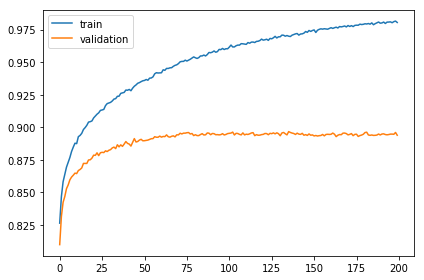

In [198]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.4, 0.4, 0.0, 0])

start = time.time()

losses5, accuracies_train5, accuracies_test5 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=200)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train5, label='train')
plt.plot(accuracies_test5, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions5 = mlp.best_model.predict(scaled_test_data)

best_accuracy5 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

Epoch: 0..
train Accuracy: 0.8025777777777777 
Validation Accuracy: 0.8023333333333333 
Loss: 1.7799919424490829 

Epoch: 1..
train Accuracy: 0.8313333333333334 
Validation Accuracy: 0.8302 
Loss: 0.9511457269400753 

Epoch: 2..
train Accuracy: 0.8434222222222222 
Validation Accuracy: 0.8404666666666667 
Loss: 0.7518268987632774 

Epoch: 3..
train Accuracy: 0.8496 
Validation Accuracy: 0.8451333333333333 
Loss: 0.6744466054447537 

Epoch: 4..
train Accuracy: 0.8556888888888889 
Validation Accuracy: 0.8501333333333333 
Loss: 0.6196067562809717 

Epoch: 5..
train Accuracy: 0.8593777777777778 
Validation Accuracy: 0.8536666666666667 
Loss: 0.5873074204700788 

Epoch: 6..
train Accuracy: 0.8634222222222222 
Validation Accuracy: 0.8552666666666666 
Loss: 0.5707954455791664 

Epoch: 7..
train Accuracy: 0.8647777777777778 
Validation Accuracy: 0.8562666666666666 
Loss: 0.543973655683717 

Epoch: 8..
train Accuracy: 0.8669777777777777 
Validation Accuracy: 0.8601333333333333 
Loss: 0.534005765

Epoch: 74..
train Accuracy: 0.9237333333333333 
Validation Accuracy: 0.8917333333333334 
Loss: 0.31370682974080405 

Epoch: 75..
train Accuracy: 0.9245111111111111 
Validation Accuracy: 0.8909333333333334 
Loss: 0.30726384613145885 

Epoch: 76..
train Accuracy: 0.9247111111111112 
Validation Accuracy: 0.8906 
Loss: 0.3040065145857575 

Epoch: 77..
train Accuracy: 0.9255333333333333 
Validation Accuracy: 0.8910666666666667 
Loss: 0.30586213035864673 

Epoch: 78..
train Accuracy: 0.9251777777777778 
Validation Accuracy: 0.8918666666666667 
Loss: 0.30533173037428085 

Epoch: 79..
train Accuracy: 0.9257333333333333 
Validation Accuracy: 0.8921333333333333 
Loss: 0.3055456163942489 

Epoch: 80..
train Accuracy: 0.9259555555555555 
Validation Accuracy: 0.8916 
Loss: 0.30023366937050383 

Epoch: 81..
train Accuracy: 0.9271777777777778 
Validation Accuracy: 0.8922666666666667 
Loss: 0.3015707590841875 

Epoch: 82..
train Accuracy: 0.9261111111111111 
Validation Accuracy: 0.8918 
Loss: 0.299919

Epoch: 148..
train Accuracy: 0.9470888888888889 
Validation Accuracy: 0.8952666666666667 
Loss: 0.25680541843643157 

Epoch: 149..
train Accuracy: 0.9466666666666667 
Validation Accuracy: 0.8950666666666667 
Loss: 0.2568785455155512 

Epoch: 150..
train Accuracy: 0.9470444444444445 
Validation Accuracy: 0.8951333333333333 
Loss: 0.2562066745517721 

Epoch: 151..
train Accuracy: 0.9472444444444444 
Validation Accuracy: 0.8948 
Loss: 0.2495120952048366 

Epoch: 152..
train Accuracy: 0.9471333333333334 
Validation Accuracy: 0.8946666666666667 
Loss: 0.25385778731995456 

Epoch: 153..
train Accuracy: 0.9466222222222223 
Validation Accuracy: 0.8922666666666667 
Loss: 0.2596144973247171 

Epoch: 154..
train Accuracy: 0.9475333333333333 
Validation Accuracy: 0.8938 
Loss: 0.25306578001316365 

Epoch: 155..
train Accuracy: 0.9488666666666666 
Validation Accuracy: 0.8947333333333334 
Loss: 0.24818536255106377 

Epoch: 156..
train Accuracy: 0.9481111111111111 
Validation Accuracy: 0.895066666666

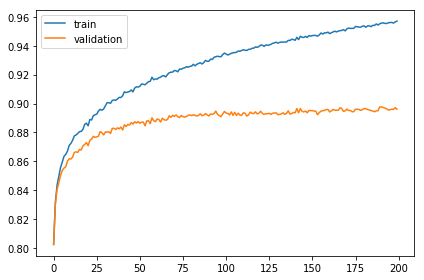

In [209]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.5, 0.5, 0.0, 0])

start = time.time()

losses6, accuracies_train6, accuracies_test6 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=200)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train6, label='train')
plt.plot(accuracies_test6, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions6 = mlp.best_model.predict(scaled_test_data)

best_accuracy6 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

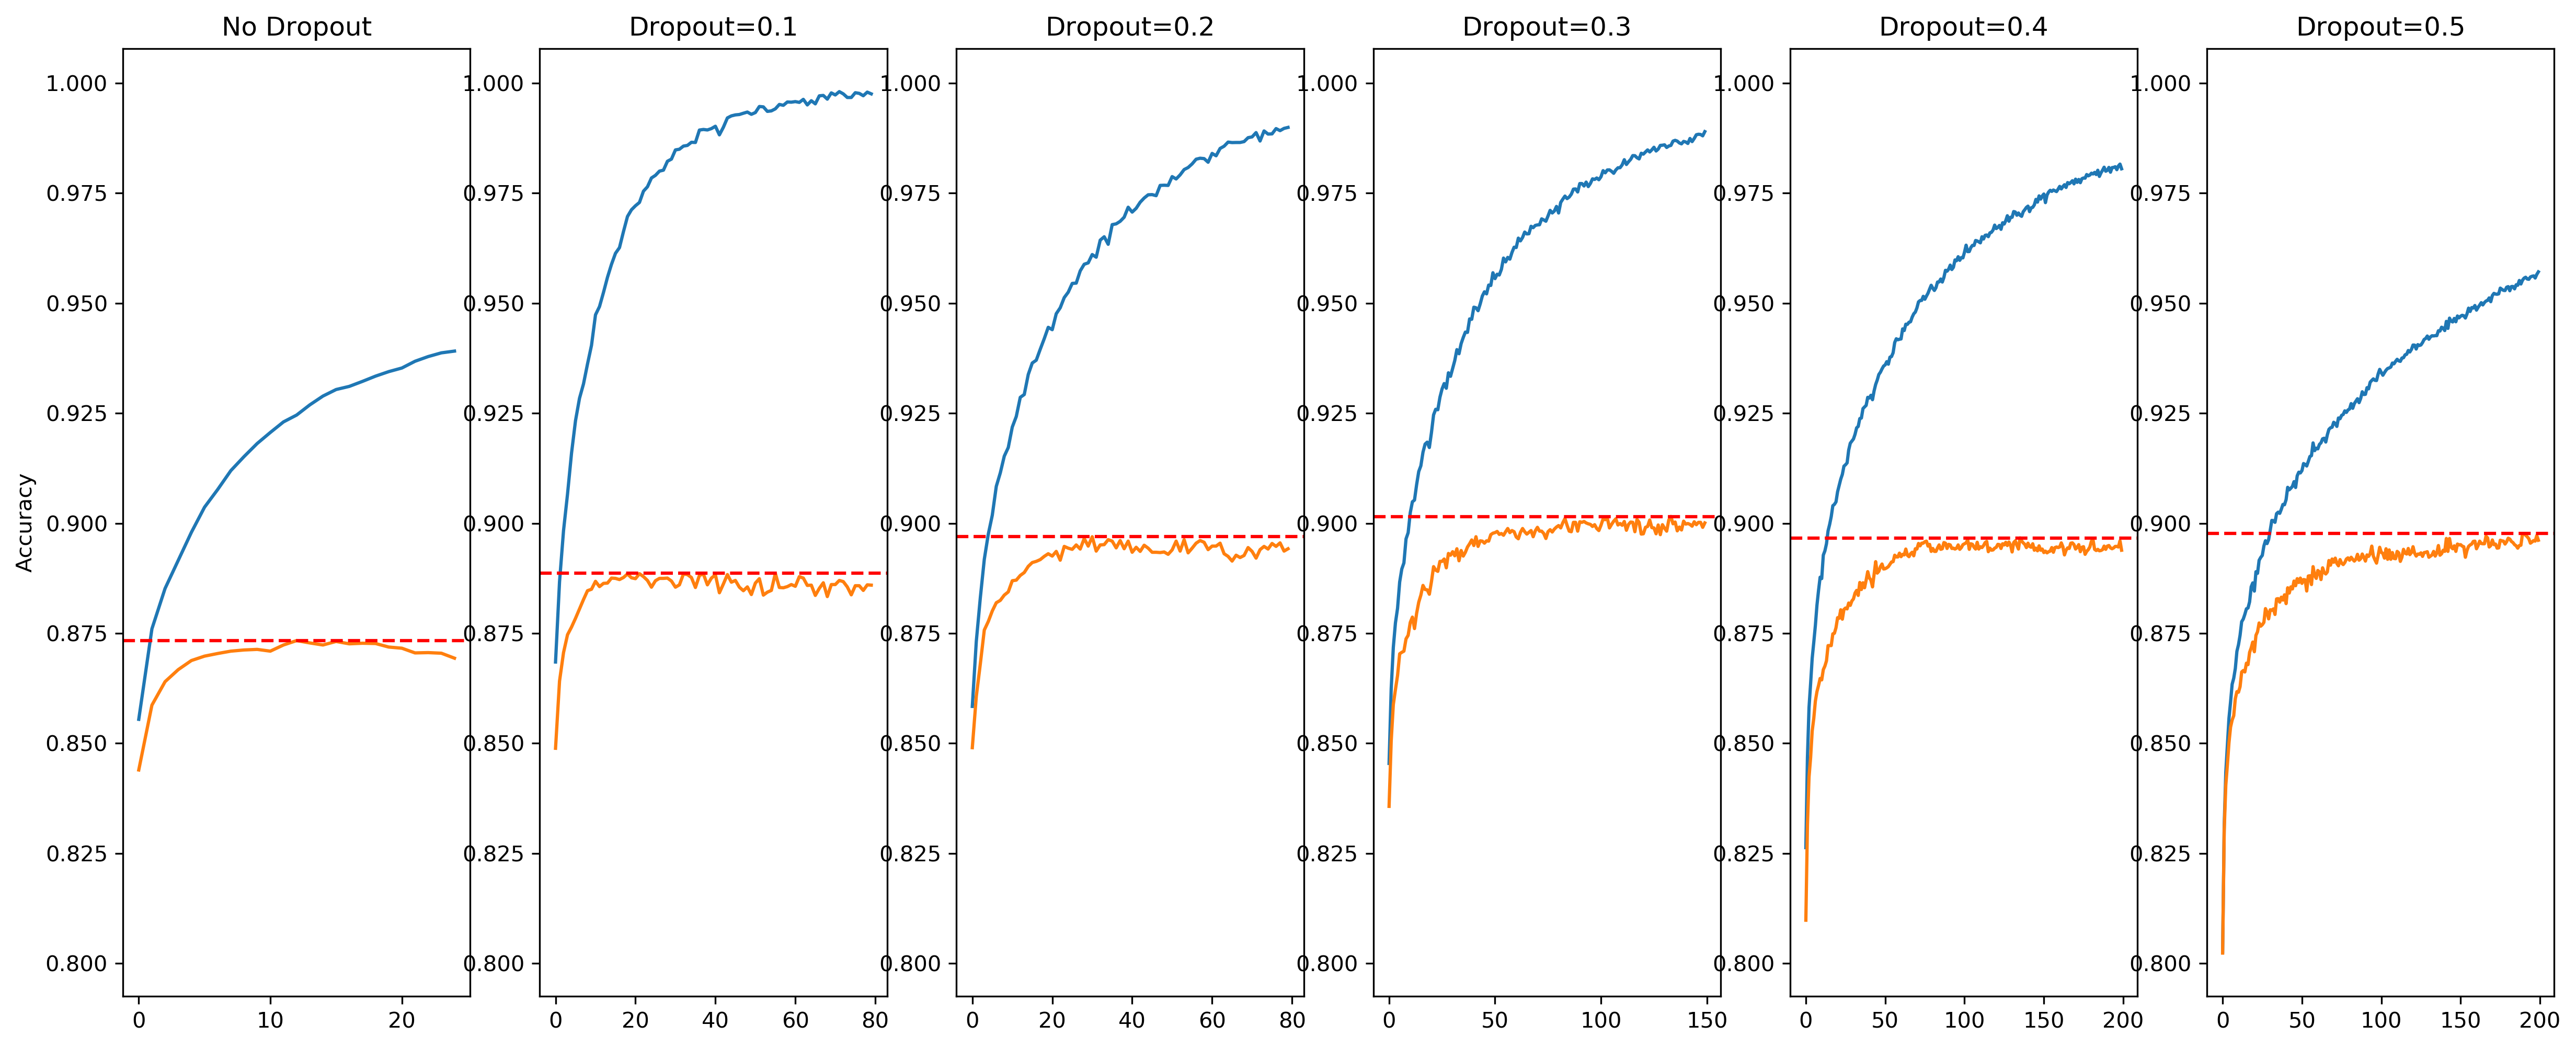

In [210]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
fig, ax = plt.subplots(figsize=(20,8),dpi=300)
#fig.set_title('Accuracy vs Dropout')
ax1 = plt.subplot(161)
ax2 = plt.subplot(162, sharey = ax1)
ax3 = plt.subplot(163, sharey = ax1)
ax4 = plt.subplot(164, sharey = ax1)
ax5 = plt.subplot(165, sharey = ax1)
ax6 = plt.subplot(166, sharey = ax1)

ax1.plot(accuracies_train1)
ax1.plot(accuracies_test1)
ax1.axhline(best_accuracy,linestyle='--',color='r')
ax2.plot(accuracies_train2)
ax2.plot(accuracies_test2)
ax2.axhline(best_accuracy2,linestyle='--',color='r')
ax3.plot(accuracies_train3)
ax3.plot(accuracies_test3)
ax3.axhline(best_accuracy3,linestyle='--',color='r')
ax4.plot(accuracies_train4)
ax4.plot(accuracies_test4)
ax4.axhline(best_accuracy4,linestyle='--',color='r')
ax5.plot(accuracies_train5)
ax5.plot(accuracies_test5)
ax5.axhline(best_accuracy5,linestyle='--',color='r')
ax6.plot(accuracies_train6)
ax6.plot(accuracies_test6)
ax6.axhline(best_accuracy6,linestyle='--',color='r')
ax1.set_title('No Dropout')
ax2.set_title('Dropout=0.1')
ax3.set_title('Dropout=0.2')
ax4.set_title('Dropout=0.3')
ax5.set_title('Dropout=0.4')
ax6.set_title('Dropout=0.5')
ax1.set_ylabel('Accuracy')
fig.savefig('Dropout.png')

Epoch: 0..
train Accuracy: 0.6691111111111111 
Validation Accuracy: 0.6686666666666666 
Loss: 1.839680937618546 

Epoch: 1..
train Accuracy: 0.7907777777777778 
Validation Accuracy: 0.7886666666666666 
Loss: 0.936276975792305 

Epoch: 2..
train Accuracy: 0.8209777777777778 
Validation Accuracy: 0.8165333333333333 
Loss: 0.6233099067150837 

Epoch: 3..
train Accuracy: 0.8331555555555555 
Validation Accuracy: 0.8285333333333333 
Loss: 0.5290783611858103 

Epoch: 4..
train Accuracy: 0.8410222222222222 
Validation Accuracy: 0.8354 
Loss: 0.4860573964072764 

Epoch: 5..
train Accuracy: 0.8471555555555556 
Validation Accuracy: 0.839 
Loss: 0.45988653599746526 

Epoch: 6..
train Accuracy: 0.8516222222222222 
Validation Accuracy: 0.8420666666666666 
Loss: 0.4411923762780788 

Epoch: 7..
train Accuracy: 0.8562222222222222 
Validation Accuracy: 0.8459333333333333 
Loss: 0.4265145532618991 

Epoch: 8..
train Accuracy: 0.8600888888888889 
Validation Accuracy: 0.8477333333333333 
Loss: 0.4142806794

Epoch: 74..
train Accuracy: 0.973 
Validation Accuracy: 0.8666 
Loss: 0.11429800901435615 

Epoch: 75..
train Accuracy: 0.9736666666666667 
Validation Accuracy: 0.8669333333333333 
Loss: 0.11169166632241315 

Epoch: 76..
train Accuracy: 0.9745333333333334 
Validation Accuracy: 0.8665333333333334 
Loss: 0.1091304983750974 

Epoch: 77..
train Accuracy: 0.9758222222222223 
Validation Accuracy: 0.8666 
Loss: 0.10661455710364709 

Epoch: 78..
train Accuracy: 0.9766666666666667 
Validation Accuracy: 0.8667333333333334 
Loss: 0.10414386319833917 

Epoch: 79..
train Accuracy: 0.9774 
Validation Accuracy: 0.8666 
Loss: 0.10171840476284885 

Time taken to train and predict: 132.19 seconds
Best accuracy achieved: 0.868 accuracy


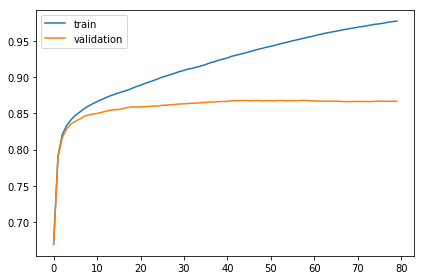

In [217]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'logistic', 'logistic','softmax'], dropout=[0.0, 0.0, 0.0, 0])

start = time.time()

losses1_sig, accuracies_train1_sig, accuracies_test1_sig = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train1_sig, label='train')
plt.plot(accuracies_test1_sig, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy1_sig = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

Epoch: 0..
train Accuracy: 0.4195333333333333 
Validation Accuracy: 0.4136 
Loss: 2.2307288004016748 

Epoch: 1..
train Accuracy: 0.5343333333333333 
Validation Accuracy: 0.5282666666666667 
Loss: 1.9782898280420445 

Epoch: 2..
train Accuracy: 0.6156444444444444 
Validation Accuracy: 0.6103333333333333 
Loss: 1.7732598256591896 

Epoch: 3..
train Accuracy: 0.6695555555555556 
Validation Accuracy: 0.6649333333333334 
Loss: 1.5849885647594726 

Epoch: 4..
train Accuracy: 0.7077555555555556 
Validation Accuracy: 0.7034 
Loss: 1.424300569188567 

Epoch: 5..
train Accuracy: 0.7339777777777777 
Validation Accuracy: 0.7290666666666666 
Loss: 1.2951510706527918 

Epoch: 6..
train Accuracy: 0.7492 
Validation Accuracy: 0.7444666666666667 
Loss: 1.2007287785658567 

Epoch: 7..
train Accuracy: 0.7667777777777778 
Validation Accuracy: 0.7593333333333333 
Loss: 1.125921797570614 

Epoch: 8..
train Accuracy: 0.7814222222222222 
Validation Accuracy: 0.7734666666666666 
Loss: 1.0580312571700177 

Epo

Epoch: 74..
train Accuracy: 0.8613777777777778 
Validation Accuracy: 0.8491333333333333 
Loss: 0.6182058092509941 

Epoch: 75..
train Accuracy: 0.8632444444444445 
Validation Accuracy: 0.8482666666666666 
Loss: 0.6103204800500851 

Epoch: 76..
train Accuracy: 0.8615333333333334 
Validation Accuracy: 0.8488666666666667 
Loss: 0.6119975654293128 

Epoch: 77..
train Accuracy: 0.8616 
Validation Accuracy: 0.8486666666666667 
Loss: 0.6176810235409842 

Epoch: 78..
train Accuracy: 0.8628666666666667 
Validation Accuracy: 0.8498666666666667 
Loss: 0.6111070168170593 

Epoch: 79..
train Accuracy: 0.8630666666666666 
Validation Accuracy: 0.849 
Loss: 0.6072959759829003 

Time taken to train and predict: 141.59 seconds
Best accuracy achieved: 0.850 accuracy


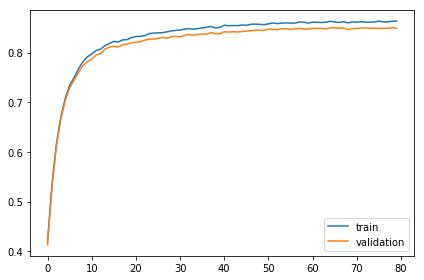

In [216]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'logistic', 'logistic','softmax'], dropout=[0.2, 0.2, 0.0, 0])

start = time.time()

losses2_sig, accuracies_train2_sig, accuracies_test2_sig = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train2_sig, label='train')
plt.plot(accuracies_test2_sig, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy2_sig = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

In [ ]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.3, 0.3, 0.0, 0])

start = time.time()

losses_flat_desc256, accuracies_train_desc256, accuracies_test_desc256 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train_desc256, label='train')
plt.plot(accuracies_test_desc256, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy_desc256 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

Epoch: 0..
train Accuracy: 0.8471777777777778 
Validation Accuracy: 0.8389333333333333 
Loss: 1.0913588429513457 

Epoch: 1..
train Accuracy: 0.8637333333333334 
Validation Accuracy: 0.8523333333333334 
Loss: 0.5667241450822263 

Epoch: 2..
train Accuracy: 0.8735111111111111 
Validation Accuracy: 0.8591333333333333 
Loss: 0.4917444503541249 

Epoch: 3..
train Accuracy: 0.8798 
Validation Accuracy: 0.8648666666666667 
Loss: 0.45745936446051816 

Epoch: 4..
train Accuracy: 0.8838888888888888 
Validation Accuracy: 0.8661333333333333 
Loss: 0.42634452030906017 

Epoch: 5..
train Accuracy: 0.8888222222222222 
Validation Accuracy: 0.8684666666666667 
Loss: 0.4069896020039093 

Epoch: 6..
train Accuracy: 0.8914222222222222 
Validation Accuracy: 0.8695333333333334 
Loss: 0.3982022792533684 

Epoch: 7..
train Accuracy: 0.8948444444444444 
Validation Accuracy: 0.8736666666666667 
Loss: 0.3807345790789539 

Epoch: 8..
train Accuracy: 0.8978888888888888 
Validation Accuracy: 0.8746 
Loss: 0.369875

Epoch: 0..
train Accuracy: 0.8294222222222222 
Validation Accuracy: 0.8296 
Loss: 1.1769340162624062 

Epoch: 1..
train Accuracy: 0.8548666666666667 
Validation Accuracy: 0.8522 
Loss: 0.6036417744973841 

Epoch: 2..
train Accuracy: 0.8638222222222223 
Validation Accuracy: 0.8606 
Loss: 0.519705747992615 

Epoch: 3..
train Accuracy: 0.8725111111111111 
Validation Accuracy: 0.8664666666666667 
Loss: 0.4790011980192074 

Epoch: 4..
train Accuracy: 0.8764888888888889 
Validation Accuracy: 0.869 
Loss: 0.4531899825059706 

Epoch: 5..
train Accuracy: 0.8812666666666666 
Validation Accuracy: 0.8736 
Loss: 0.4289313181882706 

Epoch: 6..
train Accuracy: 0.8854 
Validation Accuracy: 0.8762666666666666 
Loss: 0.41239228689334656 

Epoch: 7..
train Accuracy: 0.8878222222222222 
Validation Accuracy: 0.8769333333333333 
Loss: 0.4018286000637808 

Epoch: 8..
train Accuracy: 0.8882888888888889 
Validation Accuracy: 0.8776 
Loss: 0.390352490193663 

Epoch: 9..
train Accuracy: 0.8937777777777778 
Vali

Epoch: 74..
train Accuracy: 0.9518666666666666 
Validation Accuracy: 0.8988666666666667 
Loss: 0.2262825266604193 

Epoch: 75..
train Accuracy: 0.9526888888888889 
Validation Accuracy: 0.8986666666666666 
Loss: 0.22135060059103562 

Epoch: 76..
train Accuracy: 0.9535333333333333 
Validation Accuracy: 0.8974666666666666 
Loss: 0.22326343709257604 

Epoch: 77..
train Accuracy: 0.9532 
Validation Accuracy: 0.8982 
Loss: 0.22003704076469274 

Epoch: 78..
train Accuracy: 0.9540222222222222 
Validation Accuracy: 0.8973333333333333 
Loss: 0.21952925250146857 

Epoch: 79..
train Accuracy: 0.9532888888888889 
Validation Accuracy: 0.8996 
Loss: 0.22141709373053786 

Time taken to train and predict: 91.75 seconds
Best accuracy achieved: 0.902 accuracy


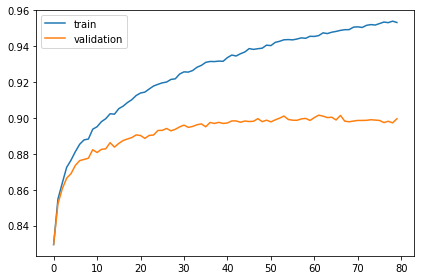

In [246]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 128, 128, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.3, 0.3, 0.0, 0])

start = time.time()

losses_desc128, accuracies_train_flat128, accuracies_test_flat128 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train_desc256, label='train')
plt.plot(accuracies_test_desc256, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy_desc256 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

Epoch: 0..
train Accuracy: 0.8526444444444444 
Validation Accuracy: 0.8431333333333333 
Loss: 0.9851084497323548 

Epoch: 1..
train Accuracy: 0.8698666666666667 
Validation Accuracy: 0.8587333333333333 
Loss: 0.5193938856557264 

Epoch: 2..
train Accuracy: 0.8797111111111111 
Validation Accuracy: 0.8656 
Loss: 0.45681697578249286 

Epoch: 3..
train Accuracy: 0.8863333333333333 
Validation Accuracy: 0.8691333333333333 
Loss: 0.4144529644787509 

Epoch: 4..
train Accuracy: 0.8928888888888888 
Validation Accuracy: 0.8744666666666666 
Loss: 0.3913278288955919 

Epoch: 5..
train Accuracy: 0.8974 
Validation Accuracy: 0.876 
Loss: 0.37322743609858783 

Epoch: 6..
train Accuracy: 0.9020666666666667 
Validation Accuracy: 0.8776 
Loss: 0.3573406001803705 

Epoch: 7..
train Accuracy: 0.9058222222222222 
Validation Accuracy: 0.8803333333333333 
Loss: 0.3446638690617632 

Epoch: 8..
train Accuracy: 0.9083111111111111 
Validation Accuracy: 0.882 
Loss: 0.3309598669302739 

Epoch: 9..
train Accuracy

Epoch: 75..
train Accuracy: 0.9843333333333333 
Validation Accuracy: 0.8968 
Loss: 0.1373623869439005 

Epoch: 76..
train Accuracy: 0.9851555555555556 
Validation Accuracy: 0.8970666666666667 
Loss: 0.1375950967833305 

Epoch: 77..
train Accuracy: 0.9850888888888889 
Validation Accuracy: 0.8985333333333333 
Loss: 0.13887642061632802 

Epoch: 78..
train Accuracy: 0.985 
Validation Accuracy: 0.8972 
Loss: 0.14059199755213153 

Epoch: 79..
train Accuracy: 0.9852666666666666 
Validation Accuracy: 0.896 
Loss: 0.1331437832716464 

Time taken to train and predict: 174.75 seconds
Best accuracy achieved: 0.899 accuracy


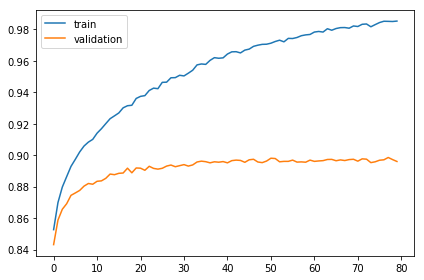

In [245]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 256, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.3, 0.3, 0.0, 0])

start = time.time()

losses_flat256, accuracies_train_flat256, accuracies_test_flat256 = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train_flat256, label='train')
plt.plot(accuracies_test_flat256, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

best_accuracy_flat256 = mlp.best_accuracy

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

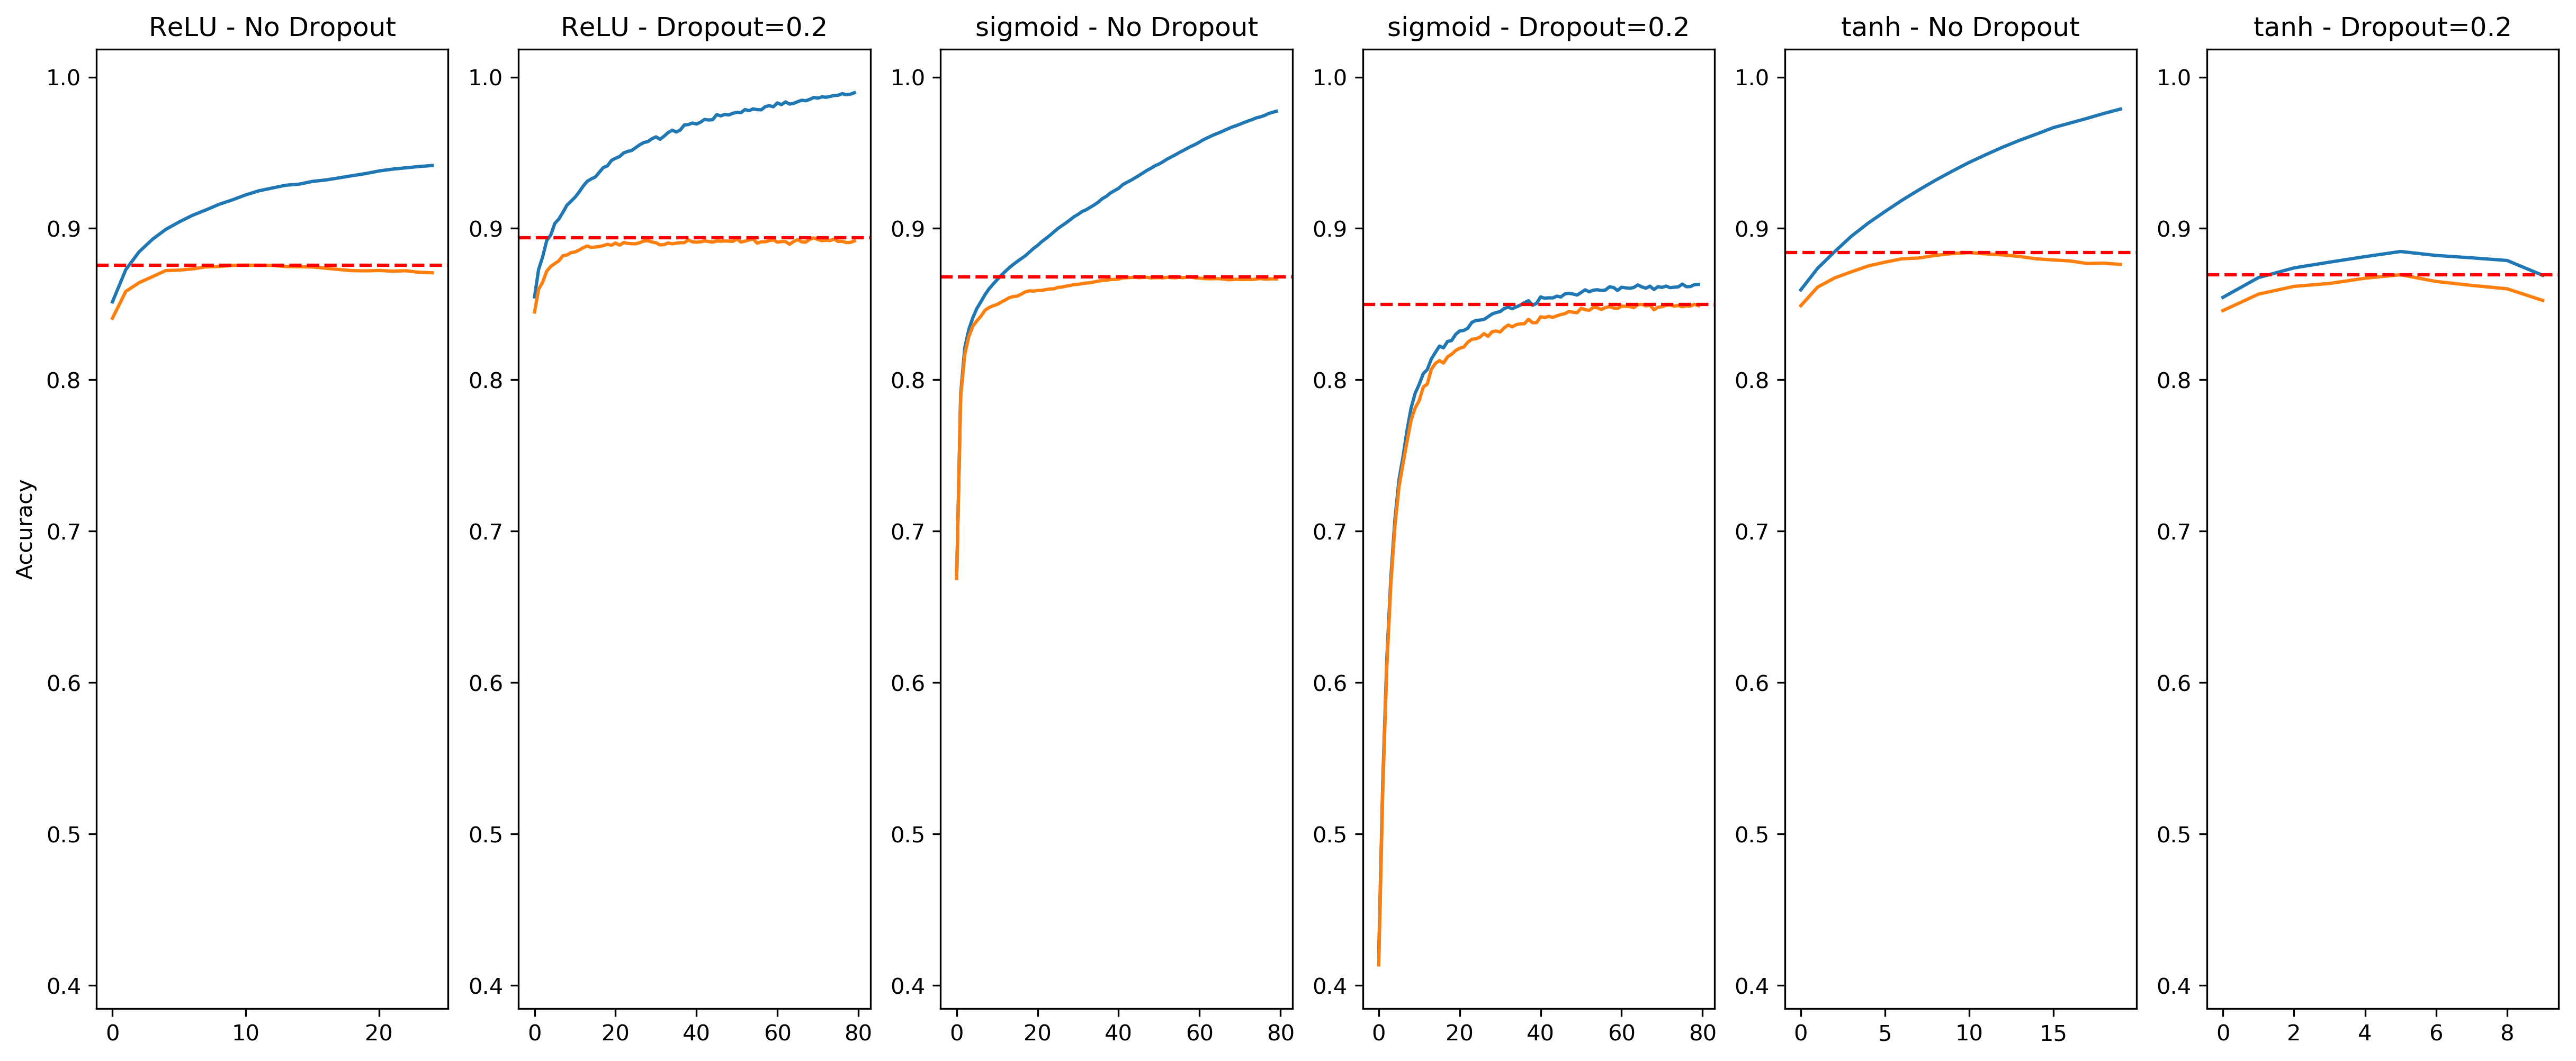

In [237]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
fig, ax = plt.subplots(figsize=(20,8),dpi=300)
#fig.set_title('Accuracy vs Dropout')
ax1 = plt.subplot(131)
ax2 = plt.subplot(132, sharey = ax1)
ax3 = plt.subplot(133, sharey = ax1)

ax1.plot(accuracies_flat256)
ax1.plot(accuracies_flat256)
ax1.axhline(best_accuracy_flat256,linestyle='--',color='r')
ax2.plot(accuracies_flat128)
ax2.plot(accuracies_flat128)
ax2.axhline(best_accuracy_flat128,linestyle='--',color='r')
ax3.plot(accuracies_train1_desc256)
ax3.plot(accuracies_test1_desc256)
ax3.axhline(best_accuracy1_desc256,linestyle='--',color='r')
ax1.set_title('ReLU - No Dropout')
ax2.set_title('ReLU - Dropout=0.2')
ax3.set_title('sigmoid - No Dropout')
ax1.set_ylabel('Accuracy')
fig.savefig('Architecture.png')

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
fig, ax = plt.subplots(figsize=(20,8),dpi=300)
#fig.set_title('Accuracy vs Dropout')
ax1 = plt.subplot(161)
ax2 = plt.subplot(162, sharey = ax1)
ax3 = plt.subplot(163, sharey = ax1)
ax4 = plt.subplot(164, sharey = ax1)
ax5 = plt.subplot(165, sharey = ax1)
ax6 = plt.subplot(166, sharey = ax1)

ax1.plot(accuracies_train1)
ax1.plot(accuracies_test1)
ax1.axhline(best_accuracy,linestyle='--',color='r')
ax2.plot(accuracies_train3)
ax2.plot(accuracies_test3)
ax2.axhline(best_accuracy2,linestyle='--',color='r')
ax3.plot(accuracies_train1_sig)
ax3.plot(accuracies_test1_sig)
ax3.axhline(best_accuracy3,linestyle='--',color='r')
ax4.plot(accuracies_train2_sig)
ax4.plot(accuracies_test2_sig)
ax4.axhline(best_accuracy4,linestyle='--',color='r')
ax5.plot(accuracies_train1_tan)
ax5.plot(accuracies_test1_tan)
ax5.axhline(best_accuracy5,linestyle='--',color='r')
ax6.plot(accuracies_train2_tan)
ax6.plot(accuracies_test2_tan)
ax6.axhline(best_accuracy6,linestyle='--',color='r')
ax1.set_title('ReLU - No Dropout')
ax2.set_title('ReLU - Dropout=0.2')
ax3.set_title('sigmoid - No Dropout')
ax4.set_title('sigmoid - Dropout=0.2')
ax5.set_title('Dropout=0.4')
ax6.set_title('Dropout=0.5')
ax1.set_ylabel('Accuracy')
fig.savefig('Dropout.png')